In [16]:
from fractions import Fraction
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_fwf('SMSSpamCollection', colspecs=[(0, 4), (4, None)], header=None, names=['target', 'message'])
#pd.set_option('display.max_rows', df.shape[0]+1)
#pd.set_option('display.max_colwidth', None)  
#display(df)
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['target'], test_size=0.25)
spam_count = y_train[y_train == 'spam'].count()
ham_count = y_train[y_train == 'ham'].count()
print('spam count = ', spam_count)
print('ham count = ', ham_count)
print('fraction of spam messages = ', Fraction(spam_count, ham_count + spam_count))

spam count =  559
ham count =  3621
fraction of spam messages =  559/4180


## Selected Metrics:
Accuracy: 95%
Precision: 98%

I chose these benchmarks for several reasons. 

For accuracy, my desired benchmark was set at 95% as I felt that anything more than 1/20 emails being incorrectly marked would be really frustrating for the user. Speaking from personal experience, if I had to constantly check my spam inbox for my emails, or if I constantly saw spam in my primary inbox, I would hate the service. Given that I also get a minimum of 20 emails every day from a variety of sources such as job applications, promotions and social media notifications, that would mean there is a chance of me missing an important email everyday.

For precision, my desired benchmark was set at 98%. I chose precision because I felt that spam being marked as a false negative is far less damaging than a real email being marked as spam (a false positive). If I had a really important email marked as spam, I would hate the spam service. Therefore, I wanted to measure how many emails are correctly marked as spam. I chose a incredibly high number, such as 98%, because the consequences can be very severe for the user if they miss a crucial email due to it incorrectly being a false positive.



In [17]:
from sklearn.metrics import confusion_matrix, make_scorer, precision_score, ConfusionMatrixDisplay
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import json

# dictionary used: https://github.com/dwyl/english-words/blob/master/words_dictionary.json

with open('words_dictionary.json', 'r') as file:
    data = json.load(file)
words_array = list(data.keys())

# vectorize training data and set up the Naive Bayes classifier
vectorizer = CountVectorizer(vocabulary=words_array, strip_accents='unicode')
vectorizer.fit(X_train, y_train)
X_train_vectorized = vectorizer.transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)
classifier = MultinomialNB()
classifier.fit(X_train_vectorized, y_train)

# predict data, then calculate accuracy and precision
train_predictions = classifier.predict(X_train_vectorized)
accuracy = cross_val_score(classifier, X_train_vectorized, y_train, cv=5, scoring='accuracy')
precision_scorer = make_scorer(precision_score, pos_label='spam')
precision = cross_val_score(classifier, X_train_vectorized, y_train, cv=5, scoring=precision_scorer)


## Bayesian training results:


Training Accuracy: 0.93 +/- 0.01
Training Precision: 1.00 +/- 0.00


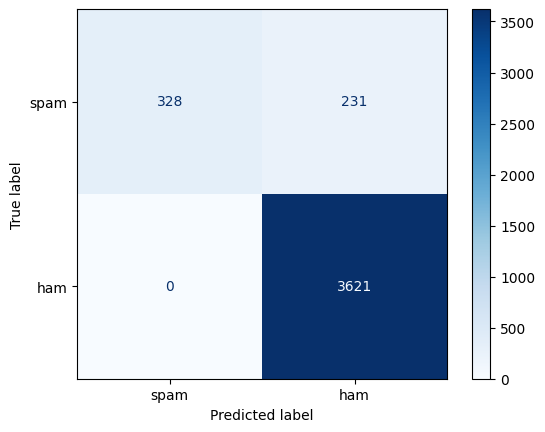

In [18]:
# take the mean and std
mean_accuracy = np.mean(accuracy)
std_accuracy = np.std(accuracy)
mean_precision = np.mean(precision)
std_precision = np.std(precision)

# print all metrics and the confusion matrix
print(f"Training Accuracy: {mean_accuracy:.2f} +/- {std_accuracy:.2f}")
print(f"Training Precision: {mean_precision:.2f} +/- {std_precision:.2f}")
disp = ConfusionMatrixDisplay.from_estimator(
    classifier,
    X_train_vectorized,
    y_train,
    display_labels=['spam', 'ham'],
    labels =['spam', 'ham'],
    cmap='Blues'
)

## Bayesian testing results:

Testing Accuracy: 0.91 +/- 0.01
Testing Precision: 1.00 +/- 0.00


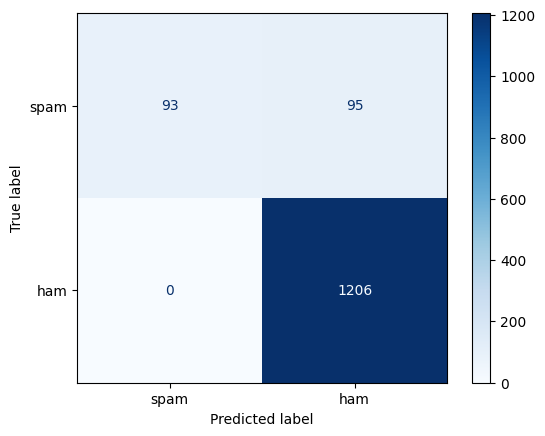

In [19]:
# predict data, then calculate accuracy and precision
test_predictions = classifier.predict(X_test_vectorized)
test_accuracy = cross_val_score(classifier, X_test_vectorized, y_test, cv=5, scoring='accuracy')
test_precision = cross_val_score(classifier, X_test_vectorized, y_test, cv=5, scoring=precision_scorer)

# take the mean and std
test_mean_accuracy = np.mean(test_accuracy)
test_std_accuracy = np.std(test_accuracy)
test_mean_precision = np.mean(test_precision)
test_std_precision = np.std(test_precision)

# print all metrics and the confusion matrix
print(f"Testing Accuracy: {test_mean_accuracy:.2f} +/- {test_std_accuracy:.2f}")
print(f"Testing Precision: {test_mean_precision:.2f} +/- {test_std_precision:.2f}")
disp2 = ConfusionMatrixDisplay.from_estimator(
    classifier,
    X_test_vectorized,
    y_test,
    display_labels=['spam', 'ham'],
    labels =['spam', 'ham'],
    cmap='Blues' 
)

## Describing my results:
My classifier performed incredibly well in that it did not predict a single ham result to be a false positive. The testing data results was within bounds set by the training data.

Whether I would use this "bare" classifier as a filter on my own messages would require further investigation. While the results seem incredibly good, they also seem too good to be true. I would definitely like to see how well this model generalizes to new unseen data across a larger sample size. 

The results are suspicious for several reasons. The most glaring issue is that the precision is a perfect 1.00 with a 0 standard deviation. I would address this issue by testing alternative models that address the class imbalance in the current data through SMOTE or other sampling techniques. I would also like to test the model across other metrics, but this assignment only calls for two metrics.

## Bayesian training learning curve:

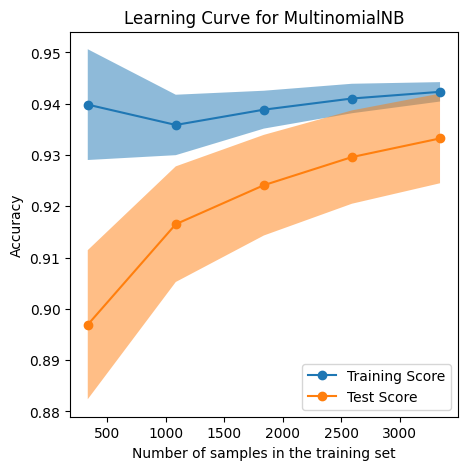

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

common_params = {
    "X": X_train_vectorized,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(classifier, **common_params, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {classifier.__class__.__name__}")

plt.show()


## What the learning curve tells us:
The learning curve suggests that when more samples are provided in the training set, the test score's accuracy also increases. This suggests that the model is still learning when the sample size of the training set increases.

## Tfidf and a logistic classifier:

Best parameters: {'logR__C': 10, 'logR__penalty': 'l2', 'tfidf__use_idf': False}
Training Accuracy: 0.98 +/- 0.00
Training Precision: 0.97 +/- 0.01
Testing Accuracy: 0.96 +/- 0.01
Testing Precision: 0.97 +/- 0.02


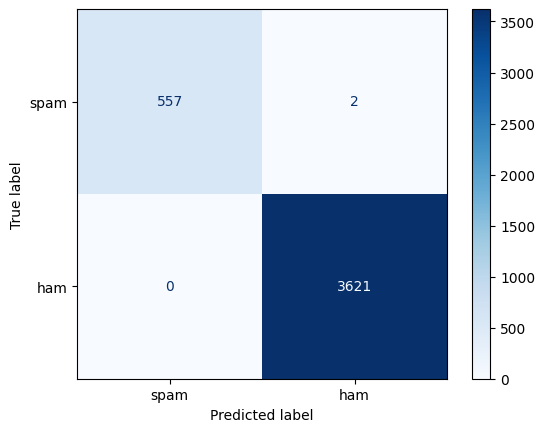

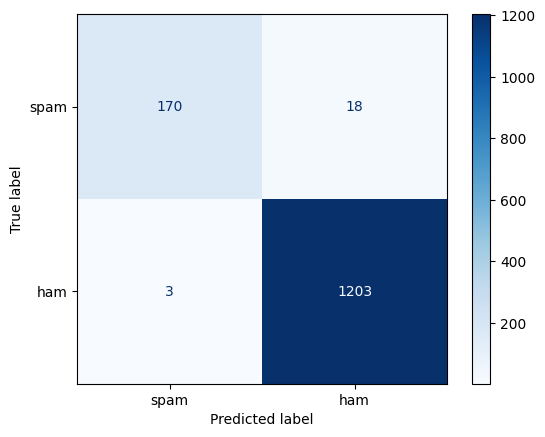

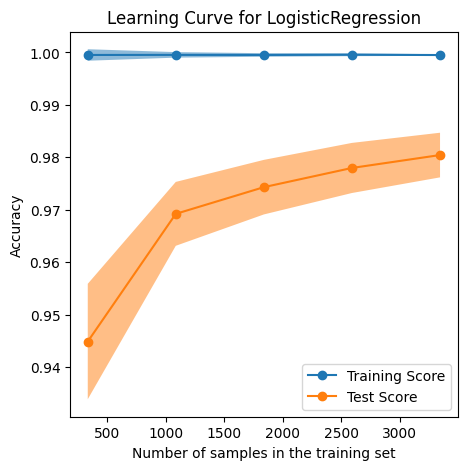

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

text_transformer = TfidfVectorizer(vocabulary=words_array, strip_accents='unicode')

X_train_tfidf = text_transformer.fit_transform(X_train)
X_test_tfidf = text_transformer.transform(X_test)


pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logR', LogisticRegression(solver='saga', max_iter=10000, tol=0.001))
])
param_grid = {
    'tfidf__use_idf': [True, False],  
    'logR__penalty': ['l1', 'l2'],   
    'logR__C': [0.01, 0.1, 1, 10, 100]  
}
grid = GridSearchCV(pipeline, param_grid, cv=5)
grid.fit(X_train, y_train)
print(f"Best parameters: {grid.best_params_}")

logR = LogisticRegression(C = 100, max_iter=1000, solver='saga', tol = 0.001, penalty='l2')
logR.fit(X_train_tfidf, y_train)
train_predictions_logr = logR.predict(X_train_tfidf)
accuracy_logr = cross_val_score(logR, X_train_tfidf, y_train, cv=5, scoring='accuracy')
precision_logr = cross_val_score(logR, X_train_tfidf, y_train, cv=5, scoring=precision_scorer)

mean_accuracy_logr = np.mean(accuracy_logr)
std_accuracy_logr = np.std(accuracy_logr)
mean_precision_logr = np.mean(precision_logr)
std_precision_logr = np.std(precision_logr)

print(f"Training Accuracy: {mean_accuracy_logr:.2f} +/- {std_accuracy_logr:.2f}")
print(f"Training Precision: {mean_precision_logr:.2f} +/- {std_precision_logr:.2f}")
disp3 = ConfusionMatrixDisplay.from_estimator(
    logR,
    X_train_tfidf,
    y_train,
    display_labels=['spam', 'ham'],
    labels =['spam', 'ham'],
    cmap='Blues'
)

test_predictions_logr = logR.predict(X_test_tfidf)
test_accuracy_logr = cross_val_score(logR, X_test_tfidf, y_test, cv=5, scoring='accuracy')
test_precision_logr = cross_val_score(logR, X_test_tfidf, y_test, cv=5, scoring=precision_scorer)

test_mean_accuracy_logr = np.mean(test_accuracy_logr)
test_std_accuracy_logr = np.std(test_accuracy_logr)
test_mean_precision_logr = np.mean(test_precision_logr)
test_std_precision_logr = np.std(test_precision_logr)

print(f"Testing Accuracy: {test_mean_accuracy_logr:.2f} +/- {test_std_accuracy_logr:.2f}")
print(f"Testing Precision: {test_mean_precision_logr:.2f} +/- {test_std_precision_logr:.2f}")
disp4 = ConfusionMatrixDisplay.from_estimator(
    logR,
    X_test_tfidf,
    y_test,
    display_labels=['spam', 'ham'],
    labels =['spam', 'ham'],
    cmap='Blues'
)




fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

common_params2 = {
    "X": X_train_tfidf,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(logR, **common_params2, ax=ax2)
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles2[:2], ["Training Score", "Test Score"])
ax2.set_title(f"Learning Curve for {logR.__class__.__name__}")

plt.show()


# Conclusions

### Training Accuracy:
- Bayesian Training Accuracy = 0.93 +/- 0.00
- Logistic Regression Training Accuracy = 0.98 +/- 0.01

### Training Precision:
- Bayesian Training Precision = 1.00 +/- 0.00
- Logistic Regression Training Precision = 0.97 +/- 0.01

### Testing Accuracy:
- Bayesian Testing Accuracy = 0.92 +/- 0.01
- Logistic Regression Testing Accuracy = 0.98 +/- 0.01

### Testing Precision:
- Bayesian Testing Precision = 1.00 +/- 0.00
- Logistic Regression Testing Precision = 0.99 +/- 0.01

The Logistic Regression model performed better across all accuracy metrics, however performed worse than the Bayesian model in precision. 
Both models have a learning curve that suggest adding labeled data to the training set would help increase accuracy for the test data.
However, the learning curves appear to approach a slope of 0, which suggests that there are diminishing returns in the increase of accuracy with the increase of data samples.
Given the two models, I would personally go with the Logistic Regression model as it performs significantly better in accuracy. Furthermore, the Logistic Regression model generalized well to the testing data making the precision differences between the models insignificant. However, I would recommend further testing regardless.

